In [2]:
# wczytanie danych oraz bibliotek
#porządkowanie danych
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns
df_comp = pd.read_csv('pogoda2_pv.csv')
df_comp['Power'] = df_comp['pv_voltage'] * df_comp['pv_current'] 
df_comp.drop(['pv_voltage','pv_current', 'battery_voltage', 'battery_current','timestamp','uv_radiation'], axis = 1, inplace = True)
df_comp.drop(['temperature','wind_speed', 'wind_dir', 'humidity','air_pressure','solar_radiation','pm2.5','luminance'], axis = 1, inplace = True)
df_comp.drop(df_comp.index[54770:132466], axis=0, inplace=True)
df_comp.drop(df_comp.index[0:39], axis=0, inplace=True)
df_comp

,data,Power
39,21-05-2021T17:00,117.315
40,21-05-2021T17:01,119.205
41,21-05-2021T17:02,119.880
42,21-05-2021T17:03,120.255
43,21-05-2021T17:04,126.320
...,...,...
54765,29-06-2021T09:56,258.950
54766,29-06-2021T09:57,251.328
54767,29-06-2021T09:58,258.600
54768,29-06-2021T09:59,261.513


In [3]:
# formatowanie datetime, frequency oraz resampling
df_comp.data=pd.to_datetime(df_comp.data, dayfirst=True)

In [4]:
df_comp.set_index('data', inplace=True)
df_comp

,Power
data,
2021-05-21 17:00:00,117.315
2021-05-21 17:01:00,119.205
2021-05-21 17:02:00,119.880
2021-05-21 17:03:00,120.255
2021-05-21 17:04:00,126.320
...,...
2021-06-29 09:56:00,258.950
2021-06-29 09:57:00,251.328
2021-06-29 09:58:00,258.600


In [5]:
df_compfreq = df_comp.asfreq('T', method = 'ffill')
df_compfreq

,Power
data,
2021-05-21 17:00:00,117.315
2021-05-21 17:01:00,119.205
2021-05-21 17:02:00,119.880
2021-05-21 17:03:00,120.255
2021-05-21 17:04:00,126.320
...,...
2021-06-29 09:56:00,258.950
2021-06-29 09:57:00,251.328
2021-06-29 09:58:00,258.600


In [6]:
#df_compresample = df_compfreq.resample('5T').agg({'temperature': np.mean, 'wind_speed': np.mean,'wind_dir': np.mean,'humidity': np.mean,'air_pressure': np.mean,'luminance': np.mean,'solar_radiation': np.mean,'pm2.5': np.mean,'Power': np.sum,})
df_compresample = df_compfreq.resample('15T').sum()
df_compresample

,Power
data,
2021-05-21 17:00:00,1809.733
2021-05-21 17:15:00,1943.081
2021-05-21 17:30:00,2074.640
2021-05-21 17:45:00,1958.147
2021-05-21 18:00:00,1815.749
...,...
2021-06-29 09:00:00,2802.620
2021-06-29 09:15:00,3083.834
2021-06-29 09:30:00,3460.044


In [7]:
df_compresample.isna().sum()

Power    0
dtype: int64

In [8]:
df_compresample.size

3717

In [9]:
# dzielenie danych na test i train
size=int(len(df_compresample)*0.8)
df=df_compresample.iloc[:size]
df_test=df_compresample.iloc[size:]

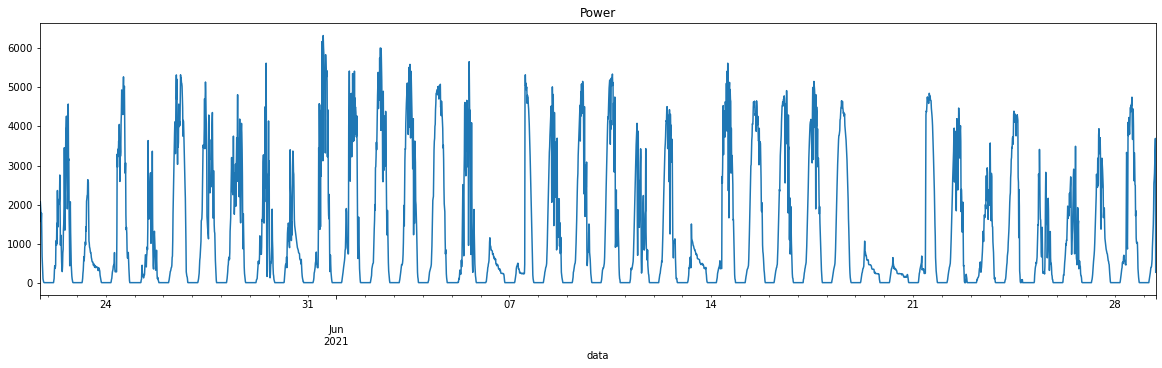

In [10]:
df_compresample.Power.plot(figsize=(20,5))
plt.title("Power")
plt.show()

In [11]:
# Dickey Fuller test
import statsmodels.tsa.stattools as sts
sts.adfuller(df.Power)

(-11.273589272168667,
 1.5156737670991346e-20,
 16,
 2956,
 {'1%': -3.432564136573189,
  '5%': -2.862518260122909,
  '10%': -2.56729075448939},
 44898.7512765082)

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 720x2880 with 0 Axes>

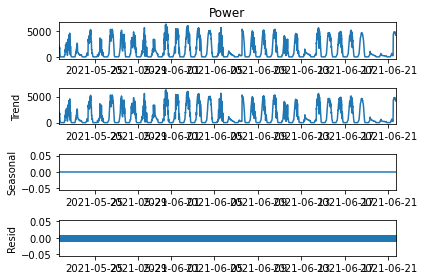

In [62]:
#Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
s_dec_additive=seasonal_decompose(df.Power, model="additive",period=1)
plt.figure(figsize=(10,40))
s_dec_additive.plot()
plt.show

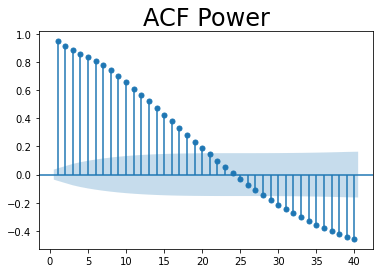

In [13]:
#Autocorrelation
sgt.plot_acf(df.Power, lags=40, zero=False)
plt.title("ACF Power", size=24)
plt.show()

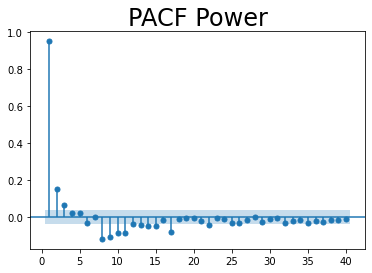

In [14]:
#Partial Autocorrelation
sgt.plot_pacf(df.Power, lags=40, zero=False, method=('ols'))
plt.title("PACF Power", size=24)
plt.show()

In [15]:
# auto arima by uzyskać rzędy dla ARMA
from pmdarima.arima import auto_arima
model_auto = auto_arima(df.Power[1:], trace=True, suppress_warnings=True)
model_auto

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=45468.619, Time=2.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52438.622, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45544.910, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=49636.747, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53759.402, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=45467.490, Time=0.77 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=48202.872, Time=1.44 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45469.874, Time=0.60 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=45469.510, Time=0.99 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=47388.876, Time=1.75 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=45466.889, Time=1.51 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=45477.564, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=45469.288, Time=1.50 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=45467.888, Time=0.31 sec
 ARIMA(3,0,2)(0,0,0

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True)

In [63]:
# model
model = ARMA(df.Power, order=(2,1))
model_fit = model.fit()
model_fit.summary()

E:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Power   No. Observations:                 2973
Model:                     ARMA(2, 1)   Log Likelihood              -22735.630
Method:                       css-mle   S.D. of innovations            506.756
Date:                Mon, 07 Mar 2022   AIC                          45481.261
Time:                        10:29:45   BIC                          45511.247
Sample:                    05-21-2021   HQIC                         45492.052
                         - 06-21-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1228.1924    237.758      5.166      0.000     762.195    1694.190
ar.L1.Power     1.1525      0.082     14.034      0.000       0.992       1.314
ar.L2.Power    -0.1773      0.079     -2.254      0.024      -0.332      -0.023
ma.L1.Power    -0.3590      0.078     -4.620      0.000      -0.511      -0.207
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0313           +0.0000j            1.0313            0.0000
AR.2            5.4675           +0.0000j            5.4675            0.0000
MA.1            2.7859           +0.0000j            2.7859            0.0000
-----------------------------------------------------------------------------
"""

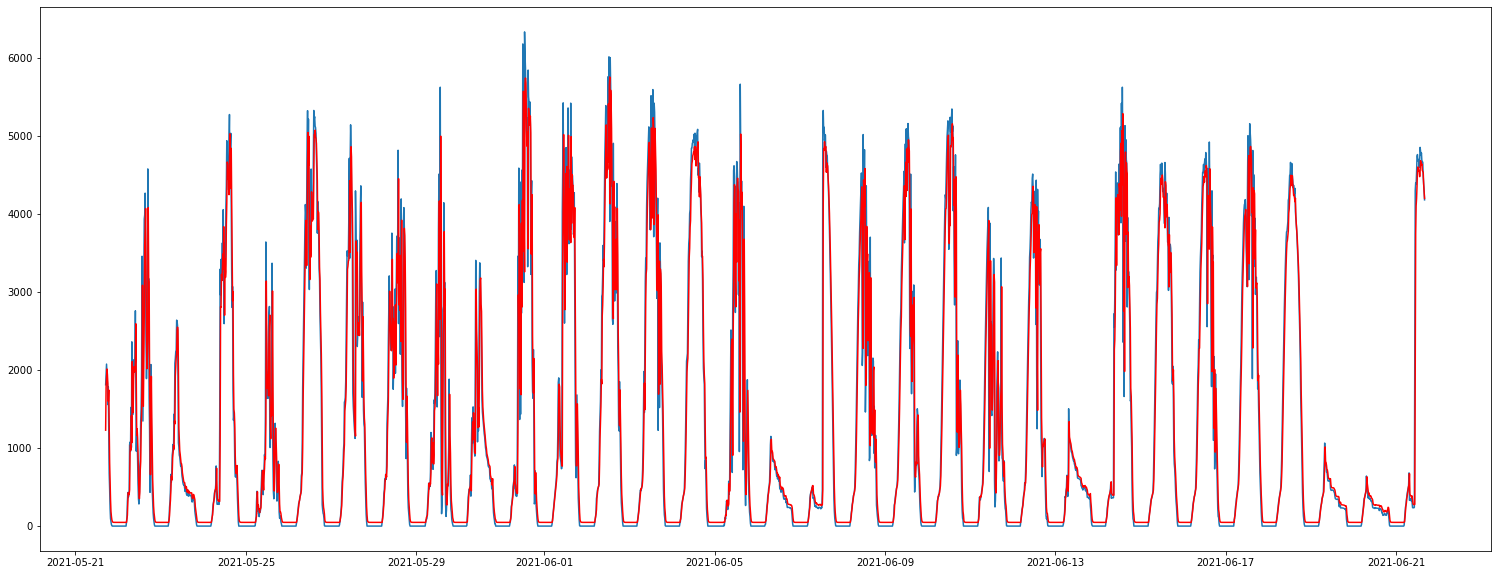

In [64]:
# wizualizacja dopasowania
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
plt.figure(figsize=(26, 10))
plt.plot(df.Power)
plt.plot(model_fit.fittedvalues, color='red')

In [65]:
# uzyskanie predykcji, wizualizacja oraz ocena
start=len(df)
end=len(df)+len(df_test)-1

pred = model_fit.predict(start=start, end=end, typ='levels')
print (pred)


2021-06-21 16:15:00    4091.719053
2021-06-21 16:30:00    4005.394469
2021-06-21 16:45:00    3921.202702
2021-06-21 17:00:00    3839.477374
2021-06-21 17:15:00    3760.216477
                          ...     
2021-06-29 09:00:00    1228.192424
2021-06-29 09:15:00    1228.192424
2021-06-29 09:30:00    1228.192424
2021-06-29 09:45:00    1228.192424
2021-06-29 10:00:00    1228.192424
Freq: 15T, Length: 744, dtype: float64


<AxesSubplot:xlabel='data'>

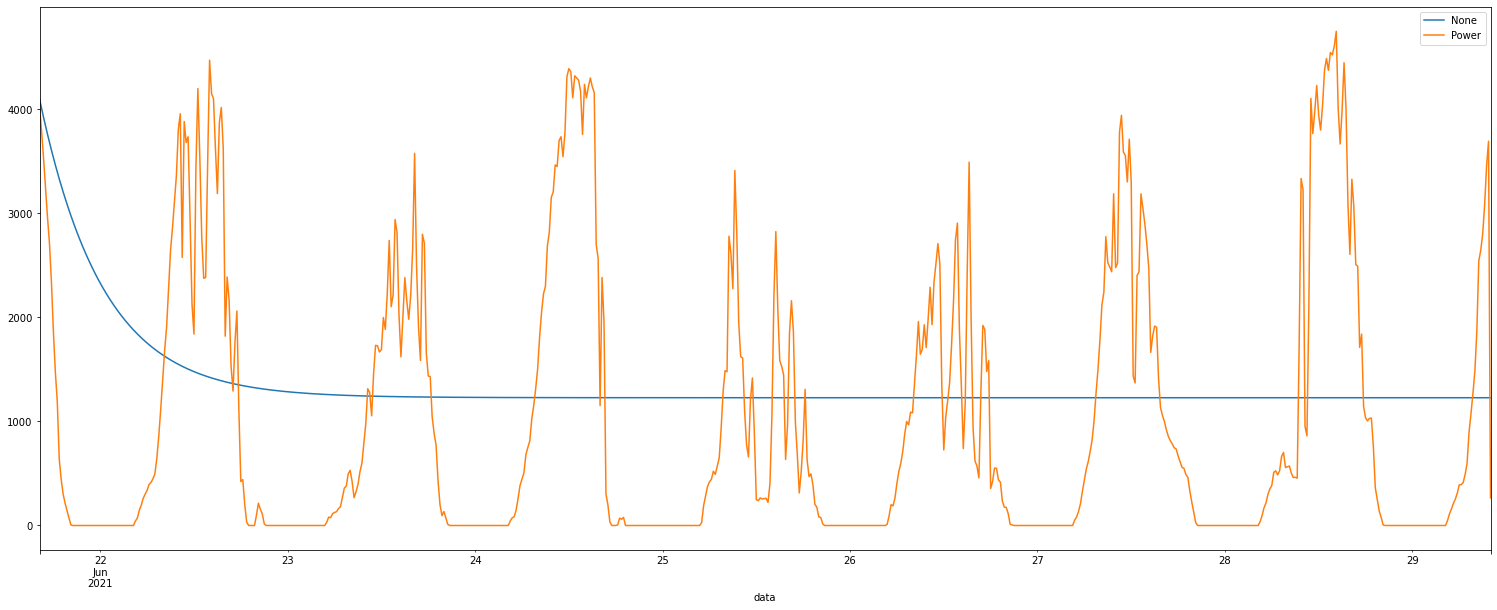

In [66]:
plt.figure(figsize=(26, 10))
pred.plot(legend=True)
df_test.Power.plot(legend=True)

In [67]:
MAE = mean_absolute_error(pred, df_test)
MDAE = median_absolute_error(pred, df_test)
MSE = mean_squared_error(pred, df_test)

print ("R2 score: " + str(r2_score(df_test, pred)))
print ("Mean Absolute Error score: " + str(MAE))
print ("Median Absolute Error score: " + str(MDAE))
print ("Mean Squared Error score: " + str(MSE))

R2 score: -0.15229086594320562
Mean Absolute Error score: 1214.03267364646
Median Absolute Error score: 1228.1924377772384
Mean Squared Error score: 1960181.1177344937


In [33]:
df_test['Power'].mean()

1014.794487903226

In [34]:
from math import sqrt
rmse=sqrt(MSE)
print(rmse)

1399.7970780396683


In [68]:
pred.head(10)

2021-06-21 16:15:00    4091.719053
2021-06-21 16:30:00    4005.394469
2021-06-21 16:45:00    3921.202702
2021-06-21 17:00:00    3839.477374
2021-06-21 17:15:00    3760.216477
2021-06-21 17:30:00    3683.358532
2021-06-21 17:45:00    3608.833034
2021-06-21 18:00:00    3536.569629
2021-06-21 18:15:00    3466.499734
2021-06-21 18:30:00    3398.556780
Freq: 15T, dtype: float64

In [69]:
df_test.head(10)

,Power
data,
2021-06-21 16:15:00,4013.934
2021-06-21 16:30:00,3777.821
2021-06-21 16:45:00,3523.616
2021-06-21 17:00:00,3243.126
2021-06-21 17:15:00,2961.444
2021-06-21 17:30:00,2712.040
2021-06-21 17:45:00,2344.162
2021-06-21 18:00:00,1868.879
2021-06-21 18:15:00,1479.427
